In [266]:
!pip install -q pandas numpy openpyxl statsmodels matplotlib seaborn


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [150]:
import os

os.makedirs("dataset", exist_ok=True)

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.titlepad'] = 20

# ind_code_s에서 7분
# ind_code_d에서 74분
# ind_code_class = "ind_code_s"
ind_code_class = "FF"

In [152]:
ff49 = pd.read_excel("./rawdata/FF49industries.xlsx")

In [153]:
ff49

,코드,한국분류,FF
0,11,작물 재배업,1_Agric
1,31,어로 어업,1_Agric
2,62,비철금속 광업,17_BldMt
3,101,"도축, 육류 가공 및 저장 처리업",2_Food
4,102,수산물 가공 및 저장 처리업,2_Food
...,...,...,...
156,857,교육 지원 서비스업,33_PerSv
157,901,창작 및 예술관련 서비스업,7_Fun
158,911,스포츠 서비스업,7_Fun
159,912,유원지 및 기타 오락관련 서비스업,7_Fun


In [154]:
df = pd.read_csv("dataset/working_capital_dataset.csv", encoding="utf-8").sort_values(["date", "firmcode"])

In [155]:
df["ind_code_s"].astype(str).str.len().value_counts()

ind_code_s
5    289476
3      4158
4      2772
Name: count, dtype: int64

In [156]:
df = pd.merge(df, ff49[["코드", "FF"]],
                left_on="ind_code_s", right_on="코드",
                how="left", indicator=True)
df._merge.value_counts()

_merge
both          289971
left_only       6435
right_only         0
Name: count, dtype: int64

In [157]:
# df= df[~df["year"].isin([2010, 2009])]

In [158]:
df[df["_merge"] == "left_only"]["ind_code_s"].value_counts()

ind_code_s
26.0000     1980
302.0000      99
733.0000      99
46.0000       99
Name: count, dtype: int64

In [159]:
df[(df["_merge"] == "left_only") & df["ind_code_s"]==26][[
    "firmcode", "ind_code_s"
]]

,firmcode,ind_code_s


In [160]:
condition = (~df["delta_cashflow"].isna()) & (~df["firm_type"].isna())

In [161]:
df = df[df["_merge"] == "both"]

In [162]:
df.columns

Index(['date', 'firmcode', 'depre', 'age', 'n_acq_intangi', 'tangi', 'intangi',
       'cash', 'payab', 'invent', 'receiv', 'st_debt', 'lt_debt', 't_debt',
       'amort', 'defer_tax_debt', 'common_mktcap', 'prefer_mktcap', 'asset',
       'exchange', 'ind_code', 'ind_code_m', 'ind_code_s', 'ind_code_d',
       'sales', 'n_acq_tangi', 'year', 'month', 'oil_price',
       'oil_price_growth', 'excel_date', 'USDKRW', 'oil_price_USDKRW',
       'ebitda', 'n_ppe', 'asset_lag', 'drop_size_dummy', 'cashflow',
       'cashflow_01', 'payab_to_sales', 'payab_to_asset', 'receiv_to_sales',
       'receiv_to_asset', 'invent_to_sales', 'invent_to_asset',
       'st_debt_to_asset', 'st_debt_to_sales', 'st_asset', 'log_sales',
       'log_st_asset', 'log_payab', 'size', 'book_lev', 'capex', 'investment',
       'n_ppe_to_asset', 'q', 'avg_cashflow', 'avg_age', 'avg_size', 'avg_q',
       'delta_cashflow', 'sup_fin', 'sup_fin_tercile', 'delta_log_sales_01',
       'delta_log_st_asset_01', 'delta_log_pa

# Ind Shock

In [163]:
import statsmodels.api as sm

def calculate_firm_beta(data, firm_col, independent_col, dependent_col):
    firm_betas = []
    for firm, group in data.groupby(firm_col):
        group = group.dropna(subset=[independent_col, dependent_col])
        
        if len(group) > 1:
            X = group[independent_col]
            y = group[dependent_col]
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            beta = model.params.iloc[1]
        else:
            beta = None 
            
        firm_betas.append({"firmcode": firm, "beta": beta})
    
    result_df = pd.DataFrame(firm_betas)
    return result_df

In [164]:
df["oil_price_growth"].describe()

count   287042.0000
mean         0.4832
std         15.0382
min        -71.2683
25%         -3.4783
50%          1.8101
75%          7.8621
max         42.0507
Name: oil_price_growth, dtype: float64

In [165]:
pd.set_option('display.float_format', lambda x: '%.12f' % x)

df["oil_price_growth"] = df["oil_price_growth"] * 1000
result = calculate_firm_beta(
    df[condition], 
    firm_col="firmcode", 
    independent_col="oil_price_growth", 
    dependent_col="delta_cashflow"
)

print(result.shape, df.shape)
print(result["beta"].value_counts(dropna=False).value_counts())
result["beta"].value_counts(dropna=False)

C:\Users\DYK\AppData\Local\Temp\ipykernel_11376\2442314140.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[condition],


(2013, 2) (289971, 86)
count
1     1952
61       1
Name: count, dtype: int64


beta
NaN                61
-0.000000083798     1
0.000000803515      1
-0.000000183213     1
0.000000004876      1
                   ..
0.000000024289      1
0.000000010499      1
-0.000000005674     1
0.000000007477      1
-0.000001331666     1
Name: count, Length: 1953, dtype: int64

In [166]:
for v in ["beta", "beta_firm", "beta_ind"]:
    if v in df.columns:
        del df[v]

df = pd.merge(df, result, on="firmcode", how="left")
df = pd.merge(df, df.groupby(ind_code_class)["beta"].mean(), 
    on=ind_code_class, how="left", suffixes=("_firm", "_ind"), validate="m:1")
df["ind_shock"] = df["oil_price_growth"] * df["beta_ind"]
df[[
    "firmcode", "oil_price_growth", "beta_firm", "beta_ind", "ind_shock"
]]

,firmcode,oil_price_growth,beta_firm,beta_ind,ind_shock
0,A000020,NaN,-0.000000083798,0.000000023557,NaN
1,A000040,NaN,0.000000119123,0.000000021817,NaN
2,A000050,NaN,-0.000000022915,0.000000023236,NaN
3,A000070,NaN,-0.000000015973,0.000000034399,NaN
4,A000080,NaN,0.000000013573,0.000000025345,NaN
...,...,...,...,...,...
289966,A950180,-3478.305600000000,NaN,0.000000034399,-0.000119649831
289967,A950190,-3478.305600000000,NaN,0.000000034399,-0.000119649831
289968,A950200,-3478.305600000000,NaN,0.000000034399,-0.000119649831
289969,A950210,-3478.305600000000,NaN,0.000000034399,-0.000119649831


In [30]:
df["beta_ind"].isna().sum()

0

##### Plot


<Axes: title={'center': 'Industry Beta Distribution'}, ylabel='Density'>

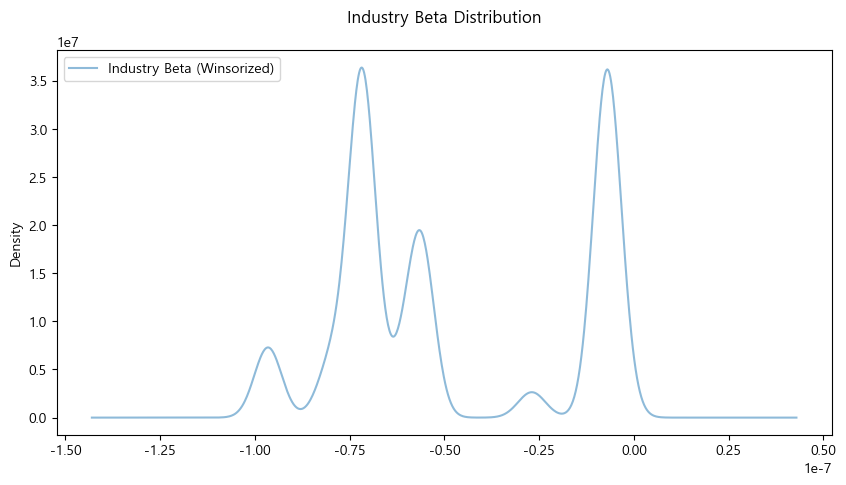

In [63]:
from scipy.stats.mstats import winsorize

filtered_data = df.loc[~df["delta_cashflow"].isna(), "beta_ind"]
winsorized_data = winsorize(filtered_data, limits=[0.01, 0.01])


pd.Series(winsorized_data).plot(
    kind="kde", alpha=0.5, figsize=(10, 5),
    label="Industry Beta (Winsorized)", legend=True, title="Industry Beta Distribution",
)

<Axes: title={'center': 'Oil Price Growth Distribution'}, ylabel='Density'>

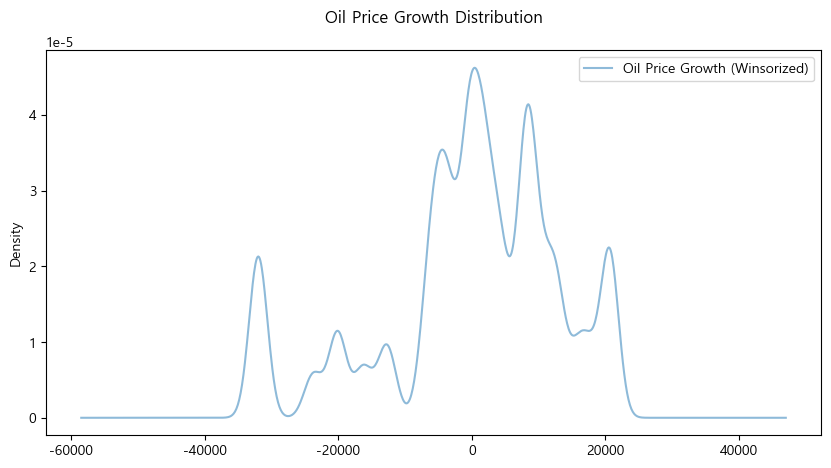

In [64]:
filtered_data = df.loc[~df["delta_cashflow"].isna(), "oil_price_growth"]
winsorized_data = winsorize(filtered_data, limits=[0.05, 0.05])


pd.Series(winsorized_data).plot(
    kind="kde", alpha=0.5, figsize=(10, 5),
    label="Oil Price Growth (Winsorized)", legend=True, title="Oil Price Growth Distribution",
)

<Axes: title={'center': 'Industry Shock Distribution [Mid-Class]'}, ylabel='Density'>

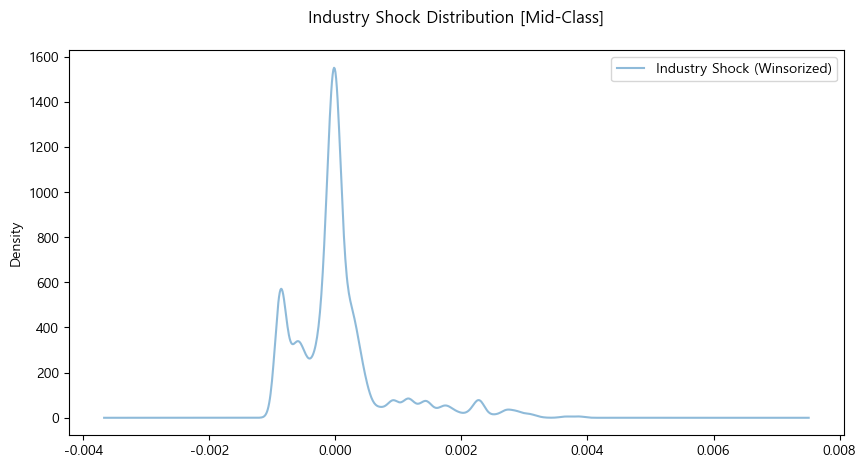

In [65]:
filtered_data = df.loc[~df["delta_cashflow"].isna(), "ind_shock"]
winsorized_data = winsorize(filtered_data, limits=[0.05, 0.05])


pd.Series(winsorized_data).plot(
    kind="kde", alpha=0.5, figsize=(10, 5),
    label="Industry Shock (Winsorized)", legend=True, title="Industry Shock Distribution [Mid-Class]",
)

<Axes: title={'center': 'Industry Shock Distribution [Mid-Class]'}, ylabel='Frequency'>

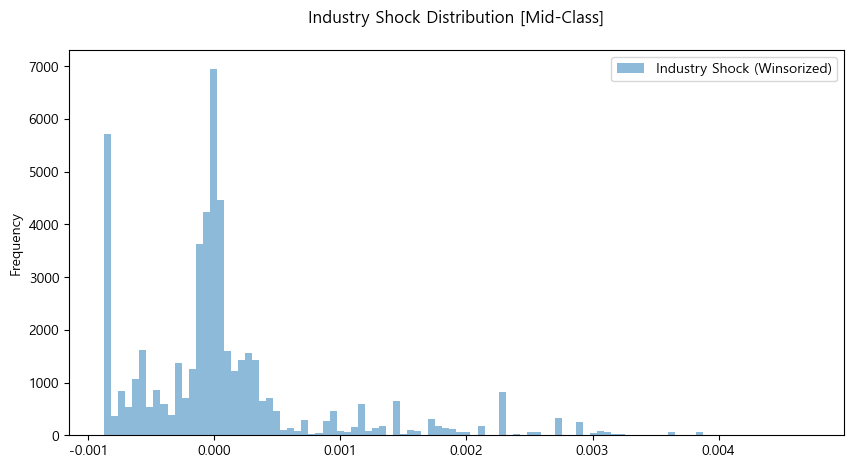

In [66]:
pd.Series(winsorized_data).plot(
    kind="hist", bins=100, alpha=0.5, figsize=(10, 5),
    label="Industry Shock (Winsorized)", legend=True, title="Industry Shock Distribution [Mid-Class]",
)

In [147]:
df.to_csv("./dataset/working_capital_dataset_oil_FF.csv", index=False, encoding="utf8")

# Table

- C(~~): Categorical Variable를 지칭 (범주형 변수)
- ! Control은 따로 명시하지 않아도 알아서 ?

In [167]:
import os

categorical_vars_path = "categorical_vars"
os.makedirs(categorical_vars_path, exist_ok=True)
categorical_vars_path = "categorical_vars" + "/multiple/FF"
os.makedirs(categorical_vars_path, exist_ok=True)

In [168]:
def _result_table(model):
    results_table = pd.DataFrame({
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        't-value': model.tvalues.values,
        'p-value': model.pvalues.values,
        'observations': int(model.nobs),
        'R-squared': model.rsquared
    })
    results_table['Significance'] = results_table['p-value'].apply(
        lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
    )
    return results_table

def summary_table(model):
    results_table = _result_table(model)
    filtered_results = results_table[~results_table['Variable'].str.contains("C\(")].reset_index(drop=True).T
    filtered_results.columns = filtered_results.loc["Variable"]
    return filtered_results.drop("Variable")

def summary_survival_table(model):
    filtered_results = _result_table(model).reset_index(drop=True)
    filtered_results = filtered_results[filtered_results["p-value"]< 0.05].reset_index(drop=True).T
    filtered_results.columns = filtered_results.loc["Variable"]
    return filtered_results.drop("Variable")

formula_str = lambda f: f"{f['Y']} ~ {' + '.join(f['X'])}"
formula_var = lambda x: [(xx[2:-1] if xx[:2]=="C(" else xx) for xx in x]

In [169]:
condition = (~df["delta_cashflow"].isna()) & (~df["firm_type"].isna()) & (df["beta_ind"]<=0)

In [170]:
# to avoid SVD did not converge error
table_cut = lambda table, col: table[table[col].map(table[col].value_counts()) > 1] 

In [171]:
import statsmodels.formula.api as smf

# 절편 없이 회귀분석
def ols_model(data, formula, title="", filter_var=None):
    if filter_var:
        data = data[data[filter_var]==1]

    temp_data = data.loc[
        (data["drop_size_dummy"]==False) 
    ].dropna(subset=[formula["Y"]])
    model = smf.ols(formula=formula_str(formula) + " + 0", data=temp_data).fit()
    if title:
        print(title)
        print(formula_str(formula) + " + 0")
        print()
        print(model.summary())
    return model

In [172]:
df["FF"] = df["FF"].str.replace("_","-")

In [173]:
def num_obs(data):
    t = data['IndustryQuarterFE'].value_counts().reset_index()
    t["industry"] = t["IndustryQuarterFE"].str.split("_").str[0]
    t["quarter"] = t["IndustryQuarterFE"].str.split("_").str[1]

    plt.figure(figsize=(20, 15))
    sns.heatmap(
        t.pivot(index="industry", columns="quarter", values="count"), annot=False, fmt=".0f", cmap="YlGnBu",
        cbar=True, square=True, xticklabels=True, yticklabels=True, 
        annot_kws={"fontsize": 7}, cbar_kws={"shrink": 0.5, "pad": 0.01}, robust=True,
    )
    plt.title(label = "Number of Observations by Industry and Quarter", fontsize=20)
    plt.xticks(rotation=45)
    plt.show()

In [174]:
import pandas as pd

def format_regression_results(variables, models, observations, r_squared, fixed_effects):
    # Initialize an empty dictionary for storing formatted data
    formatted_data = {}

    # Populate the formatted data with variable names and coefficients
    for variable in variables:
        variable_name = variable['name']
        for i, model in enumerate(models):
            if model not in formatted_data:
                formatted_data[model] = []
    
            beta = variable['beta'][i]
            t_value = variable['t_value'][i]
            p_value = variable['p_value'][i]

            # Format beta, t-value, and p-value
            if beta is not None and t_value is not None and p_value is not None:
                formatted_data[model].append(f"{beta:.3f} ({t_value:.3f}){'*' * (1 if p_value < 0.1 else 0)}")
            else:
                formatted_data[model].append("")

    # Add Observations and R-squared rows
    for i, model in enumerate(models):
        formatted_data[model].append(f"{observations[i]}")
        formatted_data[model].append(f"{r_squared[i]:.3f}")

    # Add Fixed Effects rows
    unique_effects = sorted(set(effect for model_effects in fixed_effects for effect in model_effects))
    for effect in unique_effects:
        for i, model in enumerate(models):
            formatted_data[model].append(
                "Yes" if effect in fixed_effects[i] else ""
            )

    # Construct the full table index
    full_index = [var['name'] for var in variables] + ["Observations", "R²"] + unique_effects
    # Return the formatted DataFrame
    return pd.DataFrame(formatted_data, index=full_index)


In [175]:
formula_t = {
    "X": [
        "MainQuarter", "C(Quarter)", "C(FirmType)"
    ],
    "Y": "CashFlow"
}


formula_t_plus_1 = {
    "X": [
        "MainQuarter", "C(Quarter)", "C(FirmType)"
    ],
    "Y": "CashFlow_t_plus_1"
}

print("Table II - Panel A")
print()
for v in [formula_t, formula_t_plus_1]:
    print(v)
    print(formula_str(v))
    print() 

Table II - Panel A

{'X': ['MainQuarter', 'C(Quarter)', 'C(FirmType)'], 'Y': 'CashFlow'}
CashFlow ~ MainQuarter + C(Quarter) + C(FirmType)

{'X': ['MainQuarter', 'C(Quarter)', 'C(FirmType)'], 'Y': 'CashFlow_t_plus_1'}
CashFlow_t_plus_1 ~ MainQuarter + C(Quarter) + C(FirmType)



## Table 2

In [180]:
df_table2 = df.loc[condition, [
    "firmcode", "date", "firm_type", "main_quarter", "sup_fin_tercile", 
    "oil_price_growth", "beta_firm", "beta_ind", "ind_shock", "cashflow", "cashflow_01",
    "avg_age", "avg_size", "avg_q", "avg_cashflow", "ind_code", ind_code_class, "drop_size_dummy",
    "delta_log_payab_01", "delta_log_st_asset_01", "delta_log_sales_01",
]].copy().rename(columns={
    "beta_ind": "OilExposure",
    "cashflow": "CashFlow", "cashflow_01": "CashFlow_t_plus_1", "avg_age": "Avg_Age", "avg_size": "Avg_Size", 
    "avg_q": "Avg_Q", "avg_cashflow": "Avg_CashFlow", ind_code_class: "Industry", "sup_fin_tercile": "SupFinTercile",
    "main_quarter": "MainQuarter", "firm_type": "FirmType", "oil_price_growth": "OilPriceGrowth", 
    "delta_log_payab_01": "DeltaLogAP", "delta_log_st_asset_01": "DeltaLogStAsset", "delta_log_sales_01": "DeltaLogSales"
}).dropna(subset=["FirmType", "Industry", "ind_shock", "CashFlow", "CashFlow_t_plus_1"])


### Panel A: Seasonality in Firm Profitability - Main Quarter Effect

In [181]:
panel_A_fe = ["Industry X Quarter FE", "Firm Type FE"]

num_models = 2
panel_A = {
    "title": "Table II - Panel A: Seasonality in Firm Profitability — Main Quarter Effect",
    "Y": ["Cashflow(t)", "Cashflow(t, t+1)"],
    "X": [
        {
            "name": x, "beta": [None]*num_models, "t_value": [None]*num_models, "p_value": [None]*num_models
        } for x in ['Main Quarter']
    ],
    "r_squared": [None]*num_models,
    "observations": [None]*num_models,
    "fe": [panel_A_fe, panel_A_fe],
}

In [182]:
df_table2['Industry'] = df_table2['Industry'].astype('category')  
df_table2['Quarter'] = df_table2['date'].astype('category')  
df_table2["FirmType"] = df_table2["FirmType"].astype('category')

df_table2['IndustryQuarterFE'] = df_table2['Industry'].astype(str) + "_" + df_table2['Quarter'].astype(str)
df_table2['IndustryQuarterFE'] = df_table2['IndustryQuarterFE'].astype('category')

In [183]:
df_table2["Industry"].value_counts()

Industry
21-Mach     5353
18-Cnstr    3702
20-FabPr    1748
7-Fun       1236
37-LabEq    1082
6-Toys       805
33-PerSv     750
8-Books      666
35-Comps     536
30-Oil       247
46-RlEst     230
5-Smoke       75
Name: count, dtype: int64

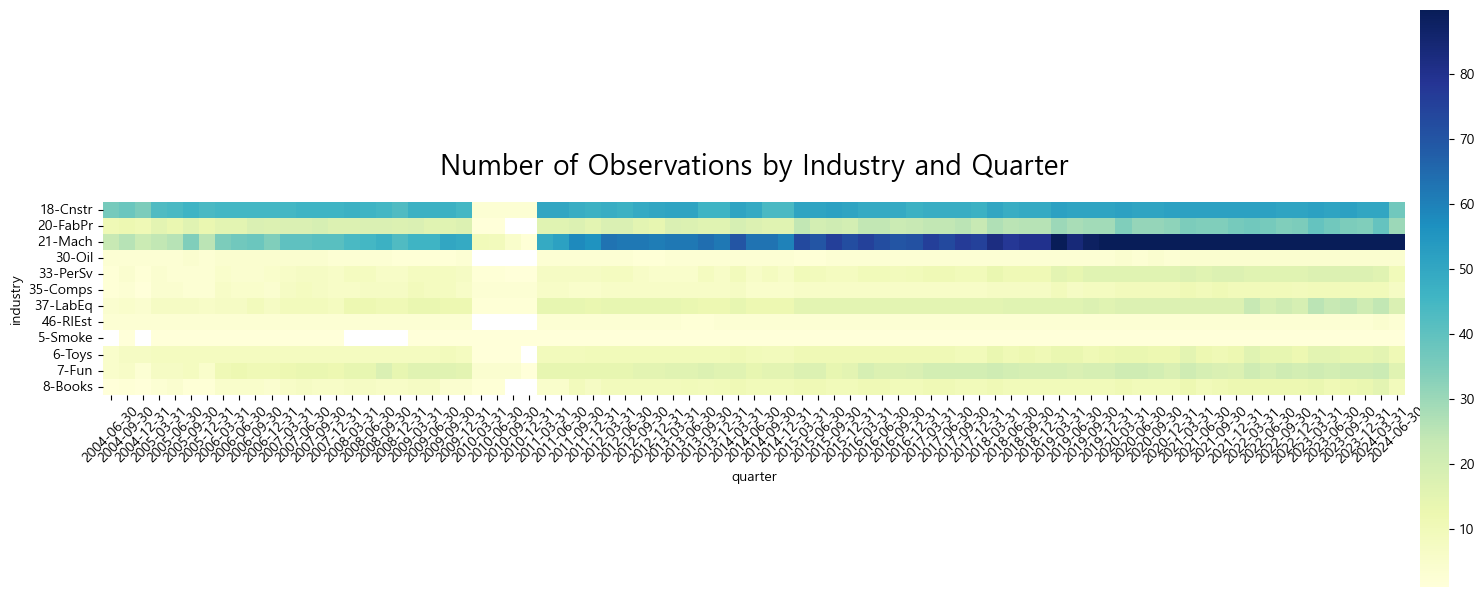

In [184]:
num_obs(df_table2)

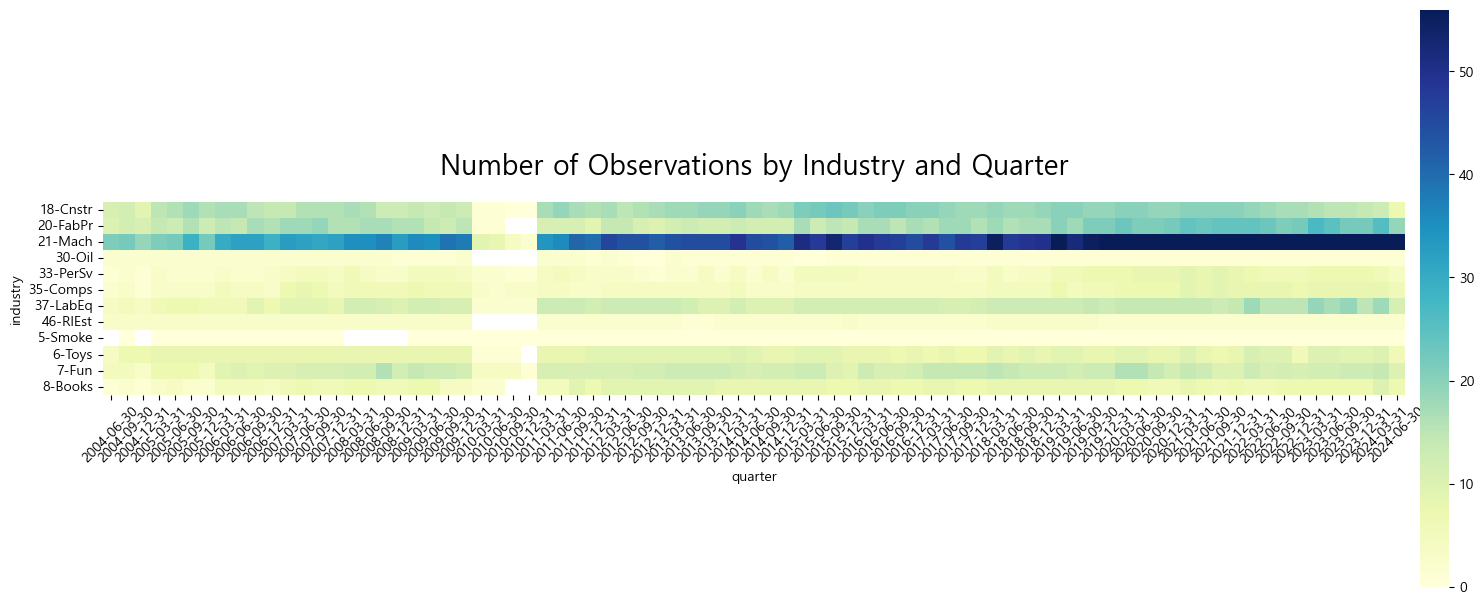

In [185]:
num_obs(df_table2[df_table2["drop_size_dummy"]==False])

In [189]:
df_table2[df_table2["drop_size_dummy"]==False]["firmcode"].nunique()

337

In [190]:
df_table2[condition].shape

C:\Users\DYK\AppData\Local\Temp\ipykernel_11376\2883591878.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2[condition].shape


(16430, 23)

In [191]:
df_table2_a = df_table2 #table_cut(df_table2, "IndustryQuarterFE")

In [193]:
df_table2_a[df_table2_a[formula_t["Y"]].notna()][["drop_size_dummy", "SupFinTercile"]].value_counts().to_frame().sort_index(ascending=False)

count
drop_size_dummy SupFinTercile       
True            top             3090
                mid             1595
                low             1495
False           top             4217
                mid             3359
                low             2661

In [195]:
model_t = ols_model(
    df_table2_a, formula_t, title = "Table II - Panel A (1): Cash Flow (t)"
)
summary_survival_table(model_t).T.to_csv(f"./{categorical_vars_path}/t2_a_1.csv")
panel_A["X"][0]["beta"][0] = model_t.params["MainQuarter"]
panel_A["X"][0]["t_value"][0] = model_t.tvalues["MainQuarter"]
panel_A["X"][0]["p_value"][0] = model_t.pvalues["MainQuarter"]
panel_A["r_squared"][0] = model_t.rsquared
panel_A["observations"][0] = int(model_t.nobs)

Table II - Panel A (1): Cash Flow (t)
CashFlow ~ MainQuarter + C(Quarter) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:               CashFlow   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.876
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           2.40e-06
Time:                        20:06:03   Log-Likelihood:                 22611.
No. Observations:               10250   AIC:                        -4.505e+04
Df Residuals:                   10165   BIC:                        -4.444e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [196]:
summary_table(model_t)

Variable,MainQuarter
Coefficient,0.000463199024
t-value,0.733379381326
p-value,0.463343983992
observations,10250
R-squared,0.015267375712
Significance,


In [197]:
# df_table2_a = table_cut(df_table2, "IndustryQuarterFE")

In [198]:
model_t_plus_1 = ols_model(
    df_table2_a, formula_t_plus_1, title = "Table II - Panel A (2): Cash Flow (t, t+1)"
)
summary_survival_table(model_t_plus_1).T.to_csv(f"./{categorical_vars_path}/t2_a_2.csv")
panel_A
panel_A["X"][0]["beta"][1] = model_t_plus_1.params["MainQuarter"]
panel_A["X"][0]["t_value"][1] = model_t_plus_1.tvalues["MainQuarter"]
panel_A["X"][0]["p_value"][1] = model_t_plus_1.pvalues["MainQuarter"]
panel_A["r_squared"][1] = model_t_plus_1.rsquared
panel_A["observations"][1] = int(model_t_plus_1.nobs)


Table II - Panel A (2): Cash Flow (t, t+1)
CashFlow_t_plus_1 ~ MainQuarter + C(Quarter) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:      CashFlow_t_plus_1   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.921
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           9.48e-07
Time:                        20:06:08   Log-Likelihood:                 16802.
No. Observations:               10250   AIC:                        -3.343e+04
Df Residuals:                   10165   BIC:                        -3.282e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------

In [199]:
summary_table(model_t_plus_1)

Variable,MainQuarter
Coefficient,0.000047979532
t-value,0.043101167871
p-value,0.965621734902
observations,10250
R-squared,0.015628709636
Significance,


In [200]:
print(panel_A["title"])

format_regression_results(
    panel_A["X"], panel_A["Y"], panel_A["observations"], panel_A["r_squared"], panel_A["fe"]
)


Table II - Panel A: Seasonality in Firm Profitability — Main Quarter Effect


,Cashflow(t),"Cashflow(t, t+1)"
Main Quarter,0.000 (0.733),0.000 (0.043)
Observations,10250,10250
R²,0.015,0.016
Firm Type FE,Yes,Yes
Industry X Quarter FE,Yes,Yes


### Panel B

In [203]:
num_models = 4
panel_B_1_fe = ['MQuarter X Firm Controls', "Industry X Quarter X SupFin Tercile FE", "Industry X Quarter X TopSupFin FE", "Firm Type FE"]

panel_B_1 = {
    "title": "Table II - Panel B: Supplier Financing during the Main Quarter \n[[ΔLog(AP)(t, t+1) - ΔLog(ST Assets)(t, t+1)]]",
    "Y": [f"({i})" for i in range(1, num_models+1)],
    "X": [{
        "name": x, "beta": [None]*num_models, "t_value": [None]*num_models, "p_value": [None]*num_models
        } for x in ['MQuarter × TopSupFin', 'MQuarter × MidSupFin']
    ],

    "r_squared": [None]*num_models,
    "observations": [None]*num_models,
    "fe": [
        [panel_B_1_fe[i] for i in [1, 3]],
        [panel_B_1_fe[i] for i in [0, 1, 3]],
        [panel_B_1_fe[i] for i in [2, 3]],
        [panel_B_1_fe[i] for i in [0, 2, 3]],
    ],
}

In [204]:
df_table2["TopSupFin"] = (df_table2["SupFinTercile"] == "top").astype(int)
df_table2["MidSupFin"] = (df_table2["SupFinTercile"] == "mid").astype(int)

df_table2["APStAsset"] = df_table2["DeltaLogAP"] - df_table2["DeltaLogStAsset"]
df_table2["APSales"] = df_table2["DeltaLogAP"] - df_table2["DeltaLogSales"]

In [205]:
df_table2['Industry'] = df_table2['Industry'].astype('category')  
df_table2['Quarter'] = df_table2['date'].astype('category')  
df_table2["FirmType"] = df_table2["FirmType"].astype('category')
df_table2["SupFinTercile"] = df_table2["SupFinTercile"].astype('category')
df_table2["MQuarter"] = df_table2["MainQuarter"].astype('category')

df_table2["MQuarterAvgAge"] = df_table2["MainQuarter"] * df_table2["Avg_Age"]
df_table2["MQuarterAvgSize"] = df_table2["MainQuarter"] * df_table2["Avg_Size"]
df_table2["MQuarterAvgQ"] = df_table2["MainQuarter"] * df_table2["Avg_Q"]
df_table2["MQuarterAvgCashFlow"] = df_table2["MainQuarter"] * df_table2["Avg_CashFlow"]


df_table2['IndustryQuarterFE'] = df_table2['Industry'].astype(str) + "_" + df_table2['Quarter'].astype(str)
df_table2["IndustryQuarterSupFinTercileFE"] = df_table2["IndustryQuarterFE"] + "_" + df_table2["SupFinTercile"].astype(str)
df_table2["IndustryQuarterTopSupFinFE"] = df_table2["IndustryQuarterFE"] + "_" + df_table2["TopSupFin"].astype('category').astype(str)

df_table2["MainQuaterXTopSupFin"] = df_table2["MainQuarter"] * df_table2["TopSupFin"]
df_table2["MainQuaterXMidSupFin"] = df_table2["MainQuarter"] * df_table2["MidSupFin"]

for v in [
    "IndustryQuarterFE", "IndustryQuarterSupFinTercileFE", "IndustryQuarterTopSupFinFE"
]:
    df_table2[v] = df_table2[v].astype('category')

# df_table2 = df_table2[df_table2['IndustryQuarterSupFinTercileFE'].map(df_table2['IndustryQuarterSupFinTercileFE'].value_counts()) > 2]

df_table2_b = df_table2 #table_cut(df_table2, "IndustryQuarterSupFinTercileFE")
df_table2_b5 = df_table2 #table_cut(df_table2, "IndustryQuarterTopSupFinFE")

In [206]:
formula_1 = {
    "X": [
        "MainQuaterXTopSupFin", "MainQuaterXMidSupFin",
        "C(IndustryQuarterSupFinTercileFE)", "C(FirmType)"  # Control Variables
    ],
    "Y": "APStAsset"
}

formula_2 = {
    "X": [
        "MainQuaterXTopSupFin", "MainQuaterXMidSupFin",
        "MQuarterAvgAge", "MQuarterAvgSize", "MQuarterAvgQ", # Control Variables
        "C(IndustryQuarterSupFinTercileFE)", "C(FirmType)"  # Control Variables
    ],
    "Y": formula_1["Y"]
}



formula_3 = {
    "X": [
        "MainQuaterXTopSupFin",
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"
    ],
    "Y": formula_1["Y"]
}

formula_4 = {
    "X": [
        "MainQuaterXTopSupFin", 
        "MQuarterAvgAge", "MQuarterAvgSize", "MQuarterAvgQ", # Control Variables
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"  # Control Variables
    ],
    "Y": formula_1["Y"]
}


formula_5 = {
    "X": [
        "MainQuaterXTopSupFin",
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"
    ],
    "Y": "APSales"
}

formula_6 = {
    "X": [
        "MainQuaterXTopSupFin",
        "MQuarterAvgAge", "MQuarterAvgSize", "MQuarterAvgQ", # Control Variables
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"
    ],
    "Y": formula_5["Y"]
}

print(formula_str(formula_5))
print(formula_var(formula_5["X"]))

APSales ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType)
['MainQuaterXTopSupFin', 'IndustryQuarterTopSupFinFE', 'FirmType']


In [207]:
print("Table II - Panel B")
print()
for i, v in enumerate([formula_1, formula_2, formula_3, formula_4, formula_5, formula_6]):
    print(i, v)
    print(formula_str(v))
    print()

Table II - Panel B

0 {'X': ['MainQuaterXTopSupFin', 'MainQuaterXMidSupFin', 'C(IndustryQuarterSupFinTercileFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + C(IndustryQuarterSupFinTercileFE) + C(FirmType)

1 {'X': ['MainQuaterXTopSupFin', 'MainQuaterXMidSupFin', 'MQuarterAvgAge', 'MQuarterAvgSize', 'MQuarterAvgQ', 'C(IndustryQuarterSupFinTercileFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterSupFinTercileFE) + C(FirmType)

2 {'X': ['MainQuaterXTopSupFin', 'C(IndustryQuarterTopSupFinFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType)

3 {'X': ['MainQuaterXTopSupFin', 'MQuarterAvgAge', 'MQuarterAvgSize', 'MQuarterAvgQ', 'C(IndustryQuarterTopSupFinFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQua

In [208]:
model_1 = ols_model(
    df_table2_b, formula_1, title = "Table II - Panel B (1): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_1).T.to_csv(f"./{categorical_vars_path}/t2_b_1.csv")

panel_B_1["X"][0]["beta"][0] = model_1.params["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["t_value"][0] = model_1.tvalues["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["p_value"][0] = model_1.pvalues["MainQuaterXTopSupFin"]
panel_B_1["X"][1]["beta"][0] = model_1.params["MainQuaterXMidSupFin"]
panel_B_1["X"][1]["t_value"][0] = model_1.tvalues["MainQuaterXMidSupFin"]
panel_B_1["X"][1]["p_value"][0] = model_1.pvalues["MainQuaterXMidSupFin"]
panel_B_1["r_squared"][0] = model_1.rsquared
panel_B_1["observations"][0] = int(model_1.nobs)

summary_table(model_1)


Table II - Panel B (1): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + C(IndustryQuarterSupFinTercileFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.277
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           3.80e-13
Time:                        20:07:02   Log-Likelihood:                -23318.
No. Observations:               10146   AIC:                         5.074e+04
Df Residuals:                    8093   BIC:                         6.557e+04
Df Model:                        2052                                         
Covariance Type:            nonrobust                                         
                                         

Variable,MainQuaterXTopSupFin,MainQuaterXMidSupFin
Coefficient,-0.067088622546,-0.152291492625
t-value,-0.631459832799,-1.213383567786
p-value,0.527757739152,0.225018617764
observations,10146,10146
R-squared,0.244583053434,0.244583053434
Significance,,


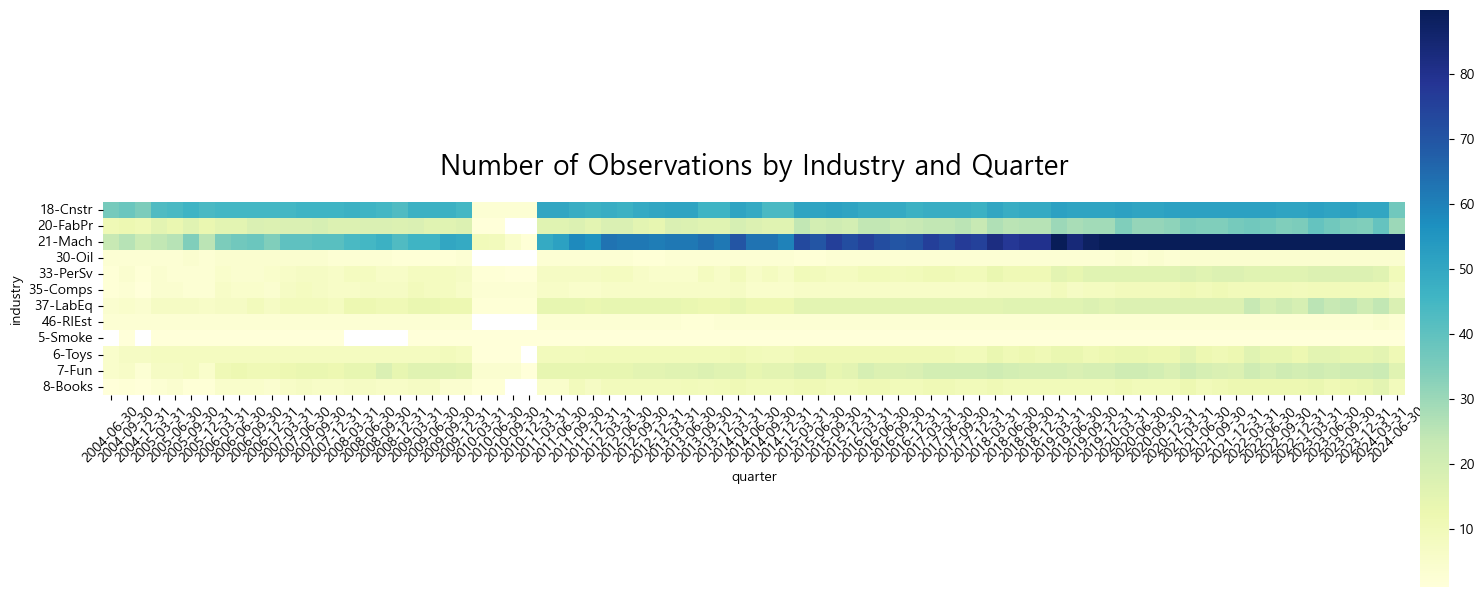

In [209]:
# df_table2_b = table_cut(df_table2_b, "IndustryQuarterSupFinTercileFE")
num_obs(df_table2_b)

In [210]:
# df_table2_b2 = table_cut(df_table2_b, "IndustryQuarterSupFinTercileFE")

In [211]:
model_2 = ols_model(
    df_table2_b, formula_2, title = "Table II - Panel B (2): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_2).T.to_csv(f"./{categorical_vars_path}/t2_b_2.csv")

panel_B_1["X"][0]["beta"][1] = model_2.params["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["t_value"][1] = model_2.tvalues["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["p_value"][1] = model_2.pvalues["MainQuaterXTopSupFin"]
panel_B_1["X"][1]["beta"][1] = model_2.params["MainQuaterXMidSupFin"]
panel_B_1["X"][1]["t_value"][1] = model_2.tvalues["MainQuaterXMidSupFin"]
panel_B_1["X"][1]["p_value"][1] = model_2.pvalues["MainQuaterXMidSupFin"]
panel_B_1["r_squared"][1] = model_2.rsquared
panel_B_1["observations"][1] = int(model_2.nobs)

Table II - Panel B (2): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterSupFinTercileFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.276
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           4.22e-13
Time:                        20:07:25   Log-Likelihood:                -23316.
No. Observations:               10146   AIC:                         5.074e+04
Df Residuals:                    8090   BIC:                         6.560e+04
Df Model:                        2055                                         
Covariance Type:            nonrobust                                 

In [212]:
summary_table(model_2)

Variable,MainQuaterXTopSupFin,MainQuaterXMidSupFin,MQuarterAvgAge,MQuarterAvgSize,MQuarterAvgQ
Coefficient,0.162370132835,0.077214640408,0.000539952683,-0.009918147093,0.002876727023
t-value,0.880311202407,0.394040391937,0.104630770825,-1.077103543356,0.042661956984
p-value,0.378716895098,0.693561603828,0.916671390919,0.281466127303,0.965972058706
observations,10146,10146,10146,10146,10146
R-squared,0.244810322992,0.244810322992,0.244810322992,0.244810322992,0.244810322992
Significance,,,,,


In [213]:
model_3 = ols_model(
    df_table2_b, formula_3, title = "Table II - Panel B (3): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_3).T.to_csv(f"./{categorical_vars_path}/t2_b_3.csv")

panel_B_1["X"][0]["beta"][2] = model_3.params["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["t_value"][2] = model_3.tvalues["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["p_value"][2] = model_3.pvalues["MainQuaterXTopSupFin"]
panel_B_1["r_squared"][2] = model_3.rsquared
panel_B_1["observations"][2] = int(model_3.nobs)

Table II - Panel B (3): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.134
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           0.000703
Time:                        20:07:39   Log-Likelihood:                -23865.
No. Observations:               10146   AIC:                         5.062e+04
Df Residuals:                    8700   BIC:                         6.107e+04
Df Model:                        1445                                         
Covariance Type:            nonrobust                                         
                                                           coef    s

In [214]:
summary_table(model_3)

Variable,MainQuaterXTopSupFin
Coefficient,-0.067232049802
t-value,-0.621662324994
p-value,0.534180218822
observations,10146
R-squared,0.158532151659
Significance,


In [215]:
model_4 = ols_model(
    df_table2_b, formula_4, title = "Table II - Panel B (4): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_4).T.to_csv(f"./{categorical_vars_path}/t2_b_4.csv")


panel_B_1["X"][0]["beta"][3] = model_4.params["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["t_value"][3] = model_4.tvalues["MainQuaterXTopSupFin"]
panel_B_1["X"][0]["p_value"][3] = model_4.pvalues["MainQuaterXTopSupFin"]
panel_B_1["r_squared"][3] = model_4.rsquared
panel_B_1["observations"][3] = int(model_4.nobs)


Table II - Panel B (4): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.134
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           0.000729
Time:                        20:07:51   Log-Likelihood:                -23863.
No. Observations:               10146   AIC:                         5.062e+04
Df Residuals:                    8697   BIC:                         6.109e+04
Df Model:                        1448                                         
Covariance Type:            nonrobust                                         
                  

In [216]:
summary_table(model_4)

Variable,MainQuaterXTopSupFin,MQuarterAvgAge,MQuarterAvgSize,MQuarterAvgQ
Coefficient,0.077981044978,0.000188760065,-0.005607589111,-0.009392539910
t-value,0.548134612886,0.037196454291,-0.706770209365,-0.143868886992
p-value,0.583613543789,0.970329219425,0.479728225363,0.885607337930
observations,10146,10146,10146,10146
R-squared,0.158785258536,0.158785258536,0.158785258536,0.158785258536
Significance,,,,


In [217]:
print(
    panel_B_1["title"]
)
format_regression_results(
    panel_B_1["X"], panel_B_1["Y"], panel_B_1["observations"], panel_B_1["r_squared"], panel_B_1["fe"]
)

Table II - Panel B: Supplier Financing during the Main Quarter 
[[ΔLog(AP)(t, t+1) - ΔLog(ST Assets)(t, t+1)]]


,(1),(2),(3),(4)
MQuarter × TopSupFin,-0.067 (-0.631),0.162 (0.880),-0.067 (-0.622),0.078 (0.548)
MQuarter × MidSupFin,-0.152 (-1.213),0.077 (0.394),,
Observations,10146,10146,10146,10146
R²,0.245,0.245,0.159,0.159
Firm Type FE,Yes,Yes,Yes,Yes
Industry X Quarter X SupFin Tercile FE,Yes,Yes,,
Industry X Quarter X TopSupFin FE,,,Yes,Yes
MQuarter X Firm Controls,,Yes,,Yes


In [227]:
num_models = 2
panel_B_1_fe = ['MQuarter X Firm Controls', "Industry X Quarter X SupFin Tercile FE", "Industry X Quarter X TopSupFin FE", "Firm Type FE"]

panel_B_2 = {
    "title": "Table II - Panel B: Supplier Financing during the Main Quarter \n[[ΔLog(AP)(t, t+1) - ΔLog(ST Assets)(t, t+1)]]",
    "Y": [f"({i})" for i in range(5, num_models+5)],
    "X": [{
        "name": x, "beta": [None]*num_models, "t_value": [None]*num_models, "p_value": [None]*num_models
        } for x in ['MQuarter × TopSupFin', 'MQuarter × MidSupFin']
    ],

    "r_squared": [None]*num_models,
    "observations": [None]*num_models,
    "fe": [
        [panel_B_1_fe[i] for i in [2, 3]],
        [panel_B_1_fe[i] for i in [0, 2, 3]],
    ],
}

In [228]:
model_5 = ols_model(
    df_table2_b5, formula_5, title = "Table II - Panel B (5): Delta Log AP - Delta Log Sales"
) 
summary_survival_table(model_5).T.to_csv(f"./{categorical_vars_path}/t2_b_5.csv")


panel_B_2["X"][0]["beta"][0] = model_5.params["MainQuaterXTopSupFin"]
panel_B_2["X"][0]["t_value"][0] = model_5.tvalues["MainQuaterXTopSupFin"]
panel_B_2["X"][0]["p_value"][0] = model_5.pvalues["MainQuaterXTopSupFin"]

panel_B_2["r_squared"][0] = model_5.rsquared
panel_B_2["observations"][0] = int(model_5.nobs)

Table II - Panel B (5): Delta Log AP - Delta Log Sales
APSales ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:                APSales   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.103
Date:                Sat, 21 Dec 2024   Prob (F-statistic):            0.00678
Time:                        20:09:10   Log-Likelihood:                -24474.
No. Observations:               10211   AIC:                         5.184e+04
Df Residuals:                    8766   BIC:                         6.229e+04
Df Model:                        1444                                         
Covariance Type:            nonrobust                                         
                                                           coef    std er

In [229]:
summary_table(model_5)

Variable,MainQuaterXTopSupFin
Coefficient,-0.071592023792
t-value,-0.633794245441
p-value,0.526231645731
observations,10211
R-squared,0.153706198605
Significance,


In [230]:
# df_table2_b5 = table_cut(df_table2_b5, "IndustryQuarterTopSupFinFE")

In [231]:
formula_str(formula_6)

'APSales ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterTopSupFinFE) + C(FirmType)'

In [232]:
model_6 = ols_model(
    df_table2_b5, formula_6, title = "Table II - Panel B (6): Delta Log AP - Delta Log Sales"
) 
summary_survival_table(model_6).T.to_csv(f"./{categorical_vars_path}/t2_b_6.csv")

panel_B_2["X"][0]["beta"][1] = model_6.params["MainQuaterXTopSupFin"]
panel_B_2["X"][0]["t_value"][1] = model_6.tvalues["MainQuaterXTopSupFin"]
panel_B_2["X"][0]["p_value"][1] = model_6.pvalues["MainQuaterXTopSupFin"]

panel_B_2["r_squared"][1] = model_6.rsquared
panel_B_2["observations"][1] = int(model_6.nobs)

Table II - Panel B (6): Delta Log AP - Delta Log Sales
APSales ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:                APSales   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.102
Date:                Sat, 21 Dec 2024   Prob (F-statistic):            0.00706
Time:                        20:09:19   Log-Likelihood:                -24472.
No. Observations:               10211   AIC:                         5.184e+04
Df Residuals:                    8763   BIC:                         6.231e+04
Df Model:                        1447                                         
Covariance Type:            nonrobust                                         
                       

In [233]:
summary_table(model_6)

Variable,MainQuaterXTopSupFin,MQuarterAvgAge,MQuarterAvgSize,MQuarterAvgQ
Coefficient,0.075126032980,-0.000137253629,-0.005760134141,0.002140325896
t-value,0.506218067209,-0.025924425495,-0.695889811088,0.031217322540
p-value,0.612716307757,0.979318208168,0.486516293582,0.975096936190
observations,10211,10211,10211,10211
R-squared,0.153934129397,0.153934129397,0.153934129397,0.153934129397
Significance,,,,


In [234]:
print(
    panel_B_2["title"]
)
format_regression_results(
    panel_B_2["X"], panel_B_2["Y"], panel_B_2["observations"], panel_B_2["r_squared"], panel_B_2["fe"]
)

Table II - Panel B: Supplier Financing during the Main Quarter 
[[ΔLog(AP)(t, t+1) - ΔLog(ST Assets)(t, t+1)]]


,(5),(6)
MQuarter × TopSupFin,-0.072 (-0.634),0.075 (0.506)
MQuarter × MidSupFin,,
Observations,10211,10211
R²,0.154,0.154
Firm Type FE,Yes,Yes
Industry X Quarter X TopSupFin FE,Yes,Yes
MQuarter X Firm Controls,,Yes


# Table 3

In [237]:
num_models = 3
panel_A = ["Industry X Quarter FE", "Shock X Firm Type FE"]

panel_A_1 = {
    "title": "Table III - Panel A: Sales Effects by Supplier Financing\nΔLog(Sales)(t, t+1)",
    "Y": [f"({i}) {v}" for i, v in enumerate(["TopSupFin", "MidSupFin", "BottomSupFin"], 1)],
    "X": [{
        "name": x, "beta": [None]*num_models, "t_value": [None]*num_models, "p_value": [None]*num_models
        } for x in ['Ind Shock × MQuarter']
    ],

    "r_squared": [None]*num_models,
    "observations": [None]*num_models,
    "fe": [
        panel_A, panel_A, panel_A, panel_A, panel_A, panel_A
    ],
}

panel_A_2 = {
    "title": "Table III - Panel A: Sales Effects by Supplier Financing\nΔLog(Sales)(t+2, t+3)",
    "Y": [f"({i}) {v}" for i, v in enumerate(["TopSupFin", "MidSupFin", "BottomSupFin"], 4)],
    "X": [{
        "name": x, "beta": [None]*num_models, "t_value": [None]*num_models, "p_value": [None]*num_models
        } for x in ['Ind Shock × MQuarter']
    ],

    "r_squared": [None]*num_models,
    "observations": [None]*num_models,
    "fe": [
        panel_A, panel_A, panel_A, panel_A, panel_A, panel_A
    ],
}

In [238]:
df_table3 = df.loc[condition, [
    "firmcode", "date", "firm_type", "main_quarter", "sup_fin_tercile", 
    "ind_shock", "cashflow", "oil_price_growth", "beta_ind",
    "avg_age", "avg_size", "avg_q", "avg_cashflow", "ind_code", ind_code_class, "drop_size_dummy",
    "delta_log_sales_01", "delta_log_sales_23",
    "age",
]].copy().rename(columns={
    "cashflow": "CashFlow", "avg_age": "Avg_Age", "avg_size": "Avg_Size", 
    "avg_q": "Avg_Q", "avg_cashflow": "Avg_CashFlow", ind_code_class: "Industry", "sup_fin_tercile": "SupFinTercile",
    "main_quarter": "MainQuarter", "firm_type": "FirmType",  
    "ind_shock": "IndustryShock", "age": "FirmAge",  "oil_price_growth": "OilPriceGrowth", "beta_ind": "OilExposure",
    "delta_log_sales_23": "DeltaLogSales23", "delta_log_sales_01": "DeltaLogSales01"
}).dropna(subset=["FirmType", "Industry"])

In [239]:
df_table3["TopSupFin"] = (df_table3["SupFinTercile"] == "top").astype(int)
df_table3["MidSupFin"] = (df_table3["SupFinTercile"] == "mid").astype(int)
df_table3["BottomSupFin"] = (df_table3["SupFinTercile"] == "low").astype(int)

df_table3['Industry'] = df_table3['Industry'].astype('category')  
df_table3['Quarter'] = df_table3['date'].astype('category')  

df_table3["IndustryShockXMainQuarter"] = df_table3["IndustryShock"] * df_table3["MainQuarter"]
df_table3["IndustryShockXMainQuarterXTopSupFin"] = df_table3["IndustryShockXMainQuarter"] * df_table3["TopSupFin"]

df_table3['IndustryQuarterFE'] = df_table3['Industry'].astype(str) + "_" + df_table3['Quarter'].astype(str)
df_table3["IndustryQuarterTopSupFinFE"] = df_table3["IndustryQuarterFE"] + "_" + df_table3["TopSupFin"].astype('category').astype(str)


In [240]:

# Shock by Firm Type FE
for i in range(1, 5):   
    df_table3[f"Q{i}"] = (df_table3["FirmType"] == i).astype(int)
for v in ["OilExposure", "OilPriceGrowth", "IndustryShock"]:
    for i in range(1, 5):   
        df_table3[f"{v}XQ{i}"] = df_table3[v] * df_table3[f"Q{i}"]

for v in ["OilExposure", "OilPriceGrowth", "IndustryShock"]:
    df_table3[f"{v}XMQuarterXAvgAge"] = df_table3["MainQuarter"] * df_table3[v] * df_table3["Avg_Age"]


In [241]:
shock_by_mquarter_by_firm_age_FE = [
    f"{category}XMQuarterXAvgAge" 
    for category in ["OilExposure", "OilPriceGrowth", "IndustryShock"]
]

shock_by_firm_type_FE = [
    f"{category}XQ{i}" 
    for category in ["OilExposure", "OilPriceGrowth", "IndustryShock"] 
    for i in range(1, 5)
]

In [242]:
df_table3_a = df_table3 #table_cut(df_table3, "IndustryQuarterFE")
df_table3_b = df_table3 #table_cut(df_table3, "IndustryQuarterTopSupFinFE")

In [243]:
df_table3_a.loc[df_table3_a["drop_size_dummy"]==False]["firmcode"].nunique()

343

In [244]:
df_table3_a.loc[df_table3_a["drop_size_dummy"]==False].groupby("SupFinTercile")["firmcode"].nunique()

SupFinTercile
low    183
mid    245
top    243
Name: firmcode, dtype: int64

In [245]:
df_table3_a.groupby("Industry")["firmcode"].nunique()

C:\Users\DYK\AppData\Local\Temp\ipykernel_11376\4184161346.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_table3_a.groupby("Industry")["firmcode"].nunique()


Industry
18-Cnstr     67
20-FabPr     49
21-Mach     149
30-Oil        5
33-PerSv     20
35-Comps     19
37-LabEq     33
46-RlEst      4
5-Smoke       1
6-Toys       17
7-Fun        36
8-Books      21
Name: firmcode, dtype: int64

### Panel A

In [246]:
formula_123 = {
    "X": [
        "IndustryShockXMainQuarter", 
        "C(IndustryQuarterFE)", # Control Variables
    ] + shock_by_firm_type_FE,
    "Y": "DeltaLogSales01"
}

formula_456 = {
    "X": formula_123["X"],
    "Y": "DeltaLogSales23"
}

print(formula_str(formula_123))
print(formula_var(formula_123["X"]))

DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4
['IndustryShockXMainQuarter', 'IndustryQuarterFE', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4']


In [247]:
print("Table III - Panel A")
print()
for i, v in enumerate([formula_123, formula_456]):
    print(i, v)
    print(formula_str(v))
    for ii, vv in enumerate(["top", "mid", "low"]):
        print("\ton", vv, "~", i*ii)
    print()

Table III - Panel A

0 {'X': ['IndustryShockXMainQuarter', 'C(IndustryQuarterFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4'], 'Y': 'DeltaLogSales01'}
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4
	on top ~ 0
	on mid ~ 0
	on low ~ 0

1 {'X': ['IndustryShockXMainQuarter', 'C(IndustryQuarterFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4'], 'Y': 'DeltaLogSales23'}
Delta

In [248]:
model_1 = ols_model(
    df_table3[df_table3["TopSupFin"]==1], 
    formula_123, title = "Table III - Panel A (1): Delta Log Sales (t, t+1) ~ TopSupFin"
)
summary_survival_table(model_1).T.to_csv(f"./{categorical_vars_path}/t3_a_1.csv")

panel_A_1["X"][0]["beta"][0] = model_1.params["IndustryShockXMainQuarter"]
panel_A_1["X"][0]["t_value"][0] = model_1.tvalues["IndustryShockXMainQuarter"]
panel_A_1["X"][0]["p_value"][0] = model_1.pvalues["IndustryShockXMainQuarter"]
panel_A_1["r_squared"][0] = model_1.rsquared
panel_A_1["observations"][0] = int(model_1.nobs)

Table III - Panel A (1): Delta Log Sales (t, t+1) ~ TopSupFin
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     2.460
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           6.12e-60
Time:                        20:13:07   Log-Likelihood:                -3204.9
No. Observations:                4427   AIC:                             7648.
Df Residuals:                    3808   BIC:                         1.161e+04
Df Model: 

In [249]:
summary_table(model_1)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,-6.962687213752,33120.051544762224,36474.380020183104,2181.735944991965,-71776.167507943086,0.000003132458,-0.000000958431,0.000002262988,-0.000002844717,5.086660283782,1.236736005114,7.055116818972,-13.372817643085
t-value,-1.405637825147,0.534965919079,0.563699359505,0.031115194887,-0.993344420991,1.841609158612,-0.537290256063,1.090949087782,-1.420291078559,0.796776878385,0.187771022284,0.839001697810,-1.661504902373
p-value,0.159913279669,0.592704659833,0.572991946422,0.975179302385,0.320605251144,0.065610064140,0.591098528021,0.275364308602,0.155604823927,0.425630298517,0.851066156916,0.401521021136,0.096694399678
observations,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427
R-squared,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691
Significance,,,,,,*,,,,,,,*


In [250]:
model_2 = ols_model(
    df_table3[df_table3["MidSupFin"]==1], 
    formula_123, title = "Table III - Panel A (2): Delta Log Sales (t, t+1) ~ MidSupFin"
)
summary_survival_table(model_2).T.to_csv(f"./{categorical_vars_path}/t3_a_2.csv")

panel_A_1["X"][0]["beta"][1] = model_2.params["IndustryShockXMainQuarter"]
panel_A_1["X"][0]["t_value"][1] = model_2.tvalues["IndustryShockXMainQuarter"]
panel_A_1["X"][0]["p_value"][1] = model_2.pvalues["IndustryShockXMainQuarter"]
panel_A_1["r_squared"][1] = model_2.rsquared
panel_A_1["observations"][1] = int(model_2.nobs)



Table III - Panel A (2): Delta Log Sales (t, t+1) ~ MidSupFin
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.195
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           0.000919
Time:                        20:13:18   Log-Likelihood:                -1769.1
No. Observations:                3510   AIC:                             5034.
Df Residuals:                    2762   BIC:                             9644.
Df Model: 

In [251]:
summary_table(model_2)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,5.235814158122,48487.346219138482,4589.849662209624,15302.822333720460,-68380.018209307178,0.000000933526,0.000000534256,0.000001073720,0.000001260187,-0.910405136702,-4.605673644283,6.354016708821,-0.859196134344
t-value,1.075699152272,0.839803732076,0.075423317837,0.243101044405,-1.103523073922,0.624441734799,0.369315574243,0.706613694450,0.735934011711,-0.170454044212,-0.761845122561,0.931964250934,-0.141273497128
p-value,0.282155780629,0.401091125707,0.939883369334,0.807945174187,0.269896211084,0.532389098947,0.711920828498,0.479866180323,0.461833350074,0.864665557358,0.446217492888,0.351436456182,0.887664188409
observations,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510
R-squared,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315
Significance,,,,,,,,,,,,,


In [252]:
model_3 = ols_model(
    df_table3[df_table3["BottomSupFin"]==1], 
    formula_123, title = "Table III - Panel A (3): Delta Log Sales (t, t+1) ~ BottomSupFin"
)
summary_survival_table(model_3).T.to_csv(f"./{categorical_vars_path}/t3_a_3.csv")

panel_A_1["X"][0]["beta"][2] = model_3.params["IndustryShockXMainQuarter"]
panel_A_1["X"][0]["t_value"][2] = model_3.tvalues["IndustryShockXMainQuarter"]
panel_A_1["X"][0]["p_value"][2] = model_3.pvalues["IndustryShockXMainQuarter"]
panel_A_1["r_squared"][2] = model_3.rsquared
panel_A_1["observations"][2] = int(model_3.nobs)


Table III - Panel A (3): Delta Log Sales (t, t+1) ~ BottomSupFin
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.9479
Date:                Sat, 21 Dec 2024   Prob (F-statistic):              0.811
Time:                        20:13:30   Log-Likelihood:                -2033.4
No. Observations:                2784   AIC:                             5603.
Df Residuals:                    2016   BIC:                         1.016e+04
Df Mode

In [253]:
summary_table(model_3)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,14.420106624450,152106.021334376128,-110334.835494755796,-105655.009870896087,63883.824040047359,0.000004806300,-0.000002944889,0.000003282995,0.000002811846,-1.098257227852,-10.178471866869,10.634760739445,0.585971740581
t-value,1.702129054501,1.492568548831,-1.071920782728,-0.987753586282,0.604236139139,2.525521782175,-1.491190764791,1.515639155857,1.365609975031,-0.129926813230,-1.291346955107,1.543182359955,0.084238923854
p-value,0.088885349752,0.135706630597,0.283883915649,0.323391875479,0.545754646882,0.011628734893,0.136067864669,0.129767390149,0.172213754187,0.896637292011,0.196731436733,0.122943482133,0.932874835226
observations,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784
R-squared,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402
Significance,*,,,,,**,,,,,,,


In [254]:
model_4 = ols_model(
    df_table3[df_table3["TopSupFin"]==1], 
    formula_456, title = "Table III - Panel A (4): Delta Log Sales (t+2, t+3) ~ TopSupFin"
)
summary_survival_table(model_4).T.to_csv(f"./{categorical_vars_path}/t3_a_4.csv")

panel_A_2["X"][0]["beta"][0] = model_4.params["IndustryShockXMainQuarter"]
panel_A_2["X"][0]["t_value"][0] = model_4.tvalues["IndustryShockXMainQuarter"]
panel_A_2["X"][0]["p_value"][0] = model_4.pvalues["IndustryShockXMainQuarter"]
panel_A_2["r_squared"][0] = model_4.rsquared
panel_A_2["observations"][0] = int(model_4.nobs)


Table III - Panel A (4): Delta Log Sales (t+2, t+3) ~ TopSupFin
DeltaLogSales23 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     2.434
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           1.56e-56
Time:                        20:13:44   Log-Likelihood:                -3823.1
No. Observations:                4266   AIC:                             8842.
Df Residuals:                    3668   BIC:                         1.264e+04
Df Model

In [138]:
summary_table(model_4)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,16.575319722160,-3056.971107804454,-556039.716491273022,522042.355872617569,37054.331706809317,0.000170644782,0.000169175381,0.000176650465,0.000168115358,-34.149794456237,-3.955108720270,89.955339163288,-51.058685246992
t-value,0.752987812747,-0.012208846791,-2.194896250017,2.026986728647,0.147522427104,1.441397268372,1.429189069296,1.491998153726,1.419909348687,-1.073135193315,-0.119964829022,2.497819247465,-1.516217577040
p-value,0.451500041931,0.990259579757,0.028226365451,0.042727714443,0.882726861096,0.149548095158,0.153025328107,0.135775804195,0.155709351026,0.283272993782,0.904516828714,0.012534490085,0.129540673051
observations,4677,4677,4677,4677,4677,4677,4677,4677,4677,4677,4677,4677,4677
R-squared,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491,0.213593143491
Significance,,,**,**,,,,,,,,**,


In [255]:
model_5 = ols_model(
    df_table3[df_table3["MidSupFin"]==1], 
    formula_456, title = "Table III - Panel A (5): Delta Log Sales (t+2, t+3) ~ MidSupFin"
)
summary_survival_table(model_5).T.to_csv(f"./{categorical_vars_path}/t3_a_5.csv")

panel_A_2["X"][0]["beta"][1] = model_5.params["IndustryShockXMainQuarter"]
panel_A_2["X"][0]["t_value"][1] = model_5.tvalues["IndustryShockXMainQuarter"]
panel_A_2["X"][0]["p_value"][1] = model_5.pvalues["IndustryShockXMainQuarter"]
panel_A_2["r_squared"][1] = model_5.rsquared
panel_A_2["observations"][1] = int(model_5.nobs)


Table III - Panel A (5): Delta Log Sales (t+2, t+3) ~ MidSupFin
DeltaLogSales23 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.174
Date:                Sat, 21 Dec 2024   Prob (F-statistic):            0.00290
Time:                        20:13:53   Log-Likelihood:                -2379.6
No. Observations:                3381   AIC:                             6213.
Df Residuals:                    2654   BIC:                         1.067e+04
Df Model

In [256]:
summary_table(model_5)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,1.475855863178,20988.993212630932,56005.192630353449,112010.351730259747,-189004.537565618404,-0.000000446511,-0.000001512584,0.000000399634,0.000001190152,-6.215489329828,-10.188912860189,4.050559528413,12.321215581631
t-value,0.246657052021,0.292431951180,0.742058877101,1.426587064395,-2.444895590113,-0.242807426475,-0.849659895656,0.211604406806,0.566126558264,-0.947618007564,-1.369924245848,0.481459525127,1.647190866645
p-value,0.805192723312,0.769979240396,0.458117327837,0.153816578011,0.014554016506,0.808173344919,0.395590838262,0.832431918419,0.571355614312,0.343410227623,0.170826430580,0.630229633081,0.099637203360
observations,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381
R-squared,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823
Significance,,,,,**,,,,,,,,*


In [257]:
model_6 = ols_model(
    df_table3[df_table3["BottomSupFin"]==1], 
    formula_456, title = "Table III - Panel A (6): Delta Log Sales (t+2, t+3) ~ BottomSupFin"
)
summary_survival_table(model_6).T.to_csv(f"./{categorical_vars_path}/t3_a_6.csv")

panel_A_2["X"][0]["beta"][2] = model_6.params["IndustryShockXMainQuarter"]
panel_A_2["X"][0]["t_value"][2] = model_6.tvalues["IndustryShockXMainQuarter"]
panel_A_2["X"][0]["p_value"][2] = model_6.pvalues["IndustryShockXMainQuarter"]
panel_A_2["r_squared"][2] = model_6.rsquared
panel_A_2["observations"][2] = int(model_6.nobs)


Table III - Panel A (6): Delta Log Sales (t+2, t+3) ~ BottomSupFin
DeltaLogSales23 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9703
Date:                Sat, 21 Dec 2024   Prob (F-statistic):              0.685
Time:                        20:14:02   Log-Likelihood:                -2650.8
No. Observations:                2648   AIC:                             6784.
Df Residuals:                    1907   BIC:                         1.114e+04
Df Mo

In [258]:
summary_table(model_6)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,16.256595375155,245653.936062505934,-295467.754483570345,-192899.767387657514,242713.585817379731,0.000002792981,0.000002854863,0.000004844976,0.000000592525,-6.463105577105,2.377463223882,8.773069146355,-4.708625191790
t-value,1.434829388863,1.735107477161,-2.078583681510,-1.312792641036,1.707840853887,1.096510386858,1.075145633693,1.675108970013,0.215407884309,-0.569497799051,0.224460821527,0.958176513025,-0.512553764537
p-value,0.151499693425,0.082883326002,0.037789051126,0.189410789488,0.087828631509,0.272993926781,0.282445539498,0.094076803709,0.829472358260,0.569085437653,0.822422795292,0.338095217053,0.608322861868
observations,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648
R-squared,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507
Significance,,*,**,,*,,,*,,,,,


In [259]:
print(
    panel_A_1["title"]
)

format_regression_results(
    panel_A_1["X"], panel_A_1["Y"], panel_A_1["observations"], panel_A_1["r_squared"], panel_A_1["fe"]
)

Table III - Panel A: Sales Effects by Supplier Financing
ΔLog(Sales)(t, t+1)


,(1) TopSupFin,(2) MidSupFin,(3) BottomSupFin
Ind Shock × MQuarter,-6.963 (-1.406),5.236 (1.076),14.420 (1.702)*
Observations,4427,3510,2784
R²,0.285,0.244,0.265
Industry X Quarter FE,Yes,Yes,Yes
Shock X Firm Type FE,Yes,Yes,Yes


In [260]:

print(
    panel_A_2["title"]
)

format_regression_results(
    panel_A_2["X"], panel_A_2["Y"], panel_A_2["observations"], panel_A_2["r_squared"], panel_A_2["fe"]
)


Table III - Panel A: Sales Effects by Supplier Financing
ΔLog(Sales)(t+2, t+3)


,(4) TopSupFin,(5) MidSupFin,(6) BottomSupFin
Ind Shock × MQuarter,-2.202 (-0.367),1.476 (0.247),16.257 (1.435)
Observations,4266,3381,2648
R²,0.284,0.243,0.274
Industry X Quarter FE,Yes,Yes,Yes
Shock X Firm Type FE,Yes,Yes,Yes


### Panel B

In [264]:
num_models = 2

panel_B_fe = [
    "Industry X Quarter X TopSupFin FE", 
    "Shock X MQuarter X Firm Age",
    "Shock X Firm Type FE"
]

panel_B_1 = {
    "title": "Table III - Panel B: Differential Effects for Top-Supplier-Financing Firms\nΔLog(Sales)(t, t+1)",
    "Y": [f"({i})" for i in range(1, num_models+1)],
    "X": [{
        "name": x, "beta": [None]*num_models, "t_value": [None]*num_models, "p_value": [None]*num_models
        } for x in ['Ind Shock × MQuarter × TopSupFin', 'Ind Shock × MQuarter']
    ],

    "r_squared": [None]*num_models,
    "observations": [None]*num_models,
    "fe": [
        [panel_B_fe[i] for i in [0, 2]],
        [panel_B_fe[i] for i in [0, 1, 2]],
    ],
}

panel_B_2 = {
    "title": "Table III - Panel B: Differential Effects for Top-Supplier-Financing Firms\nΔLog(Sales)(t+2, t+3)",
    "Y": [f"({i})" for i in range(1, num_models+1)],
    "X": [{
        "name": x, "beta": [None]*num_models, "t_value": [None]*num_models, "p_value": [None]*num_models
        } for x in ['Ind Shock × MQuarter × TopSupFin', 'Ind Shock × MQuarter']
    ],

    "r_squared": [None]*num_models,
    "observations": [None]*num_models,
    "fe": [
        [panel_B_fe[i] for i in [0, 2]],
        [panel_B_fe[i] for i in [0, 1, 2]],
    ],
}

In [265]:
formula_1 = {
    "X": [
        "IndustryShockXMainQuarterXTopSupFin", "IndustryShockXMainQuarter", 
        "C(IndustryQuarterTopSupFinFE)", 
    ] + shock_by_firm_type_FE,
    "Y": "DeltaLogSales01"
}

formula_2 = {
    "X": [
        "IndustryShockXMainQuarterXTopSupFin", 
        "C(IndustryQuarterTopSupFinFE)", 
    ] + shock_by_firm_type_FE + shock_by_mquarter_by_firm_age_FE,
    "Y": "DeltaLogSales01"
}

formula_4 = {
    "X": formula_1["X"],
    "Y": "DeltaLogSales23"
}

formula_5 = {
    "X": formula_2["X"],
    "Y": "DeltaLogSales23"
}

In [266]:
print("Table III - Panel B")
print()
for i, v in enumerate([formula_1, formula_2, {"X":[], "Y":""}, formula_4, formula_5]):
    print(i, v)
    print(formula_str(v))
    print()


Table III - Panel B

0 {'X': ['IndustryShockXMainQuarterXTopSupFin', 'IndustryShockXMainQuarter', 'C(IndustryQuarterTopSupFinFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4'], 'Y': 'DeltaLogSales01'}
DeltaLogSales01 ~ IndustryShockXMainQuarterXTopSupFin + IndustryShockXMainQuarter + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4

1 {'X': ['IndustryShockXMainQuarterXTopSupFin', 'C(IndustryQuarterTopSupFinFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustrySho

In [145]:
# df_table3_b = table_cut(df_table3, "IndustryQuarterTopSupFinFE")

In [267]:
model_1 = ols_model(
    df_table3_b, formula_1, title = "Table III - Panel B (1): Delta Log Sales (t, t+1)"
) # 18min
summary_survival_table(model_1).T.to_csv(f"./{categorical_vars_path}/t3_b_1.csv")

panel_B_1["X"][0]["beta"][0] = model_1.params["IndustryShockXMainQuarterXTopSupFin"]
panel_B_1["X"][0]["t_value"][0] = model_1.tvalues["IndustryShockXMainQuarterXTopSupFin"]
panel_B_1["X"][0]["p_value"][0] = model_1.pvalues["IndustryShockXMainQuarterXTopSupFin"]
panel_B_1["X"][1]["beta"][0] = model_1.params["IndustryShockXMainQuarter"]
panel_B_1["X"][1]["t_value"][0] = model_1.tvalues["IndustryShockXMainQuarter"]
panel_B_1["X"][1]["p_value"][0] = model_1.pvalues["IndustryShockXMainQuarter"]
panel_B_1["r_squared"][0] = model_1.rsquared
panel_B_1["observations"][0] = int(model_1.nobs)


Table III - Panel B (1): Delta Log Sales (t, t+1)
DeltaLogSales01 ~ IndustryShockXMainQuarterXTopSupFin + IndustryShockXMainQuarter + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.824
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           2.22e-60
Time:                        20:19:39   Log-Likelihood:                -7442.3
No. Observations:               10724   AIC:                         1.787e+04
Df Residuals:                    9231   BIC:          

In [268]:
summary_table(model_1)

Variable,IndustryShockXMainQuarterXTopSupFin,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,-14.006233228192,7.642875084443,60271.478146716508,-21411.822134754701,-15133.388277390672,-23726.267725402391,0.000002921970,-0.000001092950,0.000001786487,0.000000619234,2.325278330653,-4.624878533498,5.233700215543,-2.949385767414
t-value,-2.304276371900,1.890786648749,1.583996702034,-0.538270304934,-0.363043320592,-0.565168096795,1.992511521270,-0.741036396172,1.166998403254,0.407465292963,0.674391816855,-1.323170207318,1.384461211977,-0.817094811818
p-value,0.021229227635,0.058684117289,0.113228725506,0.590403427140,0.716580836165,0.571973169029,0.046344360645,0.458690222383,0.243241159570,0.683675728855,0.500079131968,0.185811554050,0.166250741532,0.413895334885
observations,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724
R-squared,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822
Significance,**,*,,,,,**,,,,,,,


In [269]:
model_2 = ols_model(
    df_table3_b, formula_2, title = "Table III - Panel B (2): Delta Log Sales (t, t+1)"
)
summary_survival_table(model_2).T.to_csv(f"./{categorical_vars_path}/t3_b_2.csv")

panel_B_1["X"][0]["beta"][1] = model_2.params["IndustryShockXMainQuarterXTopSupFin"]
panel_B_1["X"][0]["t_value"][1] = model_2.tvalues["IndustryShockXMainQuarterXTopSupFin"]
panel_B_1["X"][0]["p_value"][1] = model_2.pvalues["IndustryShockXMainQuarterXTopSupFin"]

panel_B_1["r_squared"][1] = model_2.rsquared
panel_B_1["observations"][1] = int(model_2.nobs)


Table III - Panel B (2): Delta Log Sales (t, t+1)
DeltaLogSales01 ~ IndustryShockXMainQuarterXTopSupFin + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + OilExposureXMQuarterXAvgAge + OilPriceGrowthXMQuarterXAvgAge + IndustryShockXMQuarterXAvgAge + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.823
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           2.48e-60
Time:                        20:19:56   Log-Likelihood:                -7441.1
No. Observations:               10724   AIC:                      

In [270]:
summary_table(model_2)

Variable,IndustryShockXMainQuarterXTopSupFin,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4,OilExposureXMQuarterXAvgAge,OilPriceGrowthXMQuarterXAvgAge,IndustryShockXMQuarterXAvgAge
Coefficient,-13.799313954010,60275.605563680052,-21017.250328632868,-15014.547790391203,-24243.807380205566,-0.000000504003,-0.000004490745,-0.000001745614,-0.000002876037,3.062696811651,-4.846310268936,4.787267398430,-3.172012122598,2381.568438308502,-0.000000022286,0.186927816819
t-value,-2.328042595975,1.585463221292,-0.528635615450,-0.360295887072,-0.577555767778,-0.210724455531,-1.880613446681,-0.725291538239,-1.190636189270,0.878864761304,-1.384805716916,1.262184710206,-0.878218872336,1.246069687043,-0.644411976922,1.025665810128
p-value,0.019931341017,0.112895387605,0.597070960852,0.718634119830,0.563578166663,0.833106942545,0.060055983504,0.468291585161,0.233827061231,0.379497488191,0.166145357412,0.206914223779,0.379847814709,0.212770441743,0.519324335718,0.305076017177
observations,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724
R-squared,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950
Significance,**,,,,,,*,,,,,,,,,


In [271]:
model_4 = ols_model(
    df_table3_b, formula_4, title = "Table III - Panel B (4): Delta Log Sales (t+2, t+3)"
)
summary_survival_table(model_4).T.to_csv(f"./{categorical_vars_path}/t3_b_4.csv")

panel_B_2["X"][0]["beta"][0] = model_4.params["IndustryShockXMainQuarterXTopSupFin"]
panel_B_2["X"][0]["t_value"][0] = model_4.tvalues["IndustryShockXMainQuarterXTopSupFin"]
panel_B_2["X"][0]["p_value"][0] = model_4.pvalues["IndustryShockXMainQuarterXTopSupFin"]
panel_B_2["X"][1]["beta"][0] = model_4.params["IndustryShockXMainQuarter"]
panel_B_2["X"][1]["t_value"][0] = model_4.tvalues["IndustryShockXMainQuarter"]
panel_B_2["X"][1]["p_value"][0] = model_4.pvalues["IndustryShockXMainQuarter"]


panel_B_2["r_squared"][0] = model_4.rsquared
panel_B_2["observations"][0] = int(model_4.nobs)

Table III - Panel B (4): Delta Log Sales (t+2, t+3)
DeltaLogSales23 ~ IndustryShockXMainQuarterXTopSupFin + IndustryShockXMainQuarter + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     1.720
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           2.30e-47
Time:                        20:20:31   Log-Likelihood:                -9363.3
No. Observations:               10298   AIC:                         2.162e+04
Df Residuals:                    8852   BIC:        

In [272]:
summary_table(model_4)

Variable,IndustryShockXMainQuarterXTopSupFin,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,-9.613058108685,5.825790922302,86449.221533709933,-110154.005056559778,1351.567191444761,22353.217741597724,0.000003850023,-0.000000042863,0.000003528193,0.000000750976,-0.413712780107,-2.838791009227,5.730764664347,-2.426079775128
t-value,-1.254400347377,1.152299872852,1.786926482372,-2.173108868122,0.025497703835,0.418557063488,3.218569404604,-0.036119658408,2.729558343272,0.583836880762,-0.093903846385,-0.632970811649,1.209760778239,-0.532949874288
p-value,0.209729647386,0.249228987002,0.073983578297,0.029798553958,0.979658554712,0.675550028853,0.001292961268,0.971187761852,0.006354458519,0.559344938655,0.925187663637,0.526769054929,0.226403006310,0.594081658118
observations,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298
R-squared,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953
Significance,,,*,**,,,***,,***,,,,,


In [273]:
model_5 = ols_model(
    df_table3_b, formula_5, title = "Table III - Panel B (5): Delta Log Sales (t+2, t+3)"
)
summary_survival_table(model_5).T.to_csv(f"./{categorical_vars_path}/t3_b_5.csv")

panel_B_2["X"][0]["beta"][1] = model_5.params["IndustryShockXMainQuarterXTopSupFin"]
panel_B_2["X"][0]["t_value"][1] = model_5.tvalues["IndustryShockXMainQuarterXTopSupFin"]
panel_B_2["X"][0]["p_value"][1] = model_5.pvalues["IndustryShockXMainQuarterXTopSupFin"]

panel_B_2["r_squared"][1] = model_5.rsquared
panel_B_2["observations"][1] = int(model_5.nobs)


Table III - Panel B (5): Delta Log Sales (t+2, t+3)
DeltaLogSales23 ~ IndustryShockXMainQuarterXTopSupFin + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + OilExposureXMQuarterXAvgAge + OilPriceGrowthXMQuarterXAvgAge + IndustryShockXMQuarterXAvgAge + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     1.722
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           1.15e-47
Time:                        20:20:42   Log-Likelihood:                -9359.8
No. Observations:               10298   AIC:                    

In [274]:
summary_table(model_5)

Variable,IndustryShockXMainQuarterXTopSupFin,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4,OilExposureXMQuarterXAvgAge,OilPriceGrowthXMQuarterXAvgAge,IndustryShockXMQuarterXAvgAge
Coefficient,-10.161691553293,85155.845882057358,-109107.557018141131,2762.810075782832,21188.900893641006,0.000013314895,0.000009267118,0.000012494011,0.000009853277,1.122078959075,-2.856474521835,4.917443787870,-2.693584044608,2666.171502384230,-0.000000091669,-0.099820796869
t-value,-1.360526191671,1.762331330035,-2.153835647795,0.052151044843,0.396818858968,2.522101575012,1.752951292813,2.352982417664,1.860126101125,0.252413560191,-0.636245523879,1.033971437566,-0.591590033774,1.095106176086,-2.097608472719,-0.435720900477
p-value,0.173698119038,0.078047848339,0.031279981415,0.958409517385,0.691510611019,0.011682999353,0.079644989613,0.018645278910,0.062900837322,0.800727281714,0.524632859383,0.301177769035,0.554140259719,0.273499924925,0.035968037031,0.663049866567
observations,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298
R-squared,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041
Significance,,*,**,,,**,*,**,*,,,,,,**,


In [275]:

print(
    panel_B_1["title"]
)

format_regression_results(
    panel_B_1["X"], panel_B_1["Y"], panel_B_1["observations"], panel_B_1["r_squared"], panel_B_1["fe"]
)


Table III - Panel B: Differential Effects for Top-Supplier-Financing Firms
ΔLog(Sales)(t, t+1)


,(1),(2)
Ind Shock × MQuarter × TopSupFin,-14.006 (-2.304)*,-13.799 (-2.328)*
Ind Shock × MQuarter,7.643 (1.891)*,
Observations,10724,10724
R²,0.228,0.228
Industry X Quarter X TopSupFin FE,Yes,Yes
Shock X Firm Type FE,Yes,Yes
Shock X MQuarter X Firm Age,,Yes


In [276]:
print(
    panel_B_2["title"]
)

format_regression_results(
    panel_B_2["X"], panel_B_2["Y"], panel_B_2["observations"], panel_B_2["r_squared"], panel_B_2["fe"]
)

Table III - Panel B: Differential Effects for Top-Supplier-Financing Firms
ΔLog(Sales)(t+2, t+3)


,(1),(2)
Ind Shock × MQuarter × TopSupFin,-9.613 (-1.254),-10.162 (-1.361)
Ind Shock × MQuarter,5.826 (1.152),
Observations,10298,10298
R²,0.219,0.220
Industry X Quarter X TopSupFin FE,Yes,Yes
Shock X Firm Type FE,Yes,Yes
Shock X MQuarter X Firm Age,,Yes
